# Módulo 2 Implementación de un modelo de deep learning
## Docente: Benjamin
## José Antonio López Saldaña A01710367
---

*Creación de modelos de Deepfake 7-clases (CNN de 0 y CNN pre-creada)*

## *Division de Datos en carpetas*: 💻
---

**Inicializar entorno, paths e instalacion de librerías**

*Importo librerias, y verifico mi GPU dentro de Tensorflow, finalmente instalo versiones sin conflictos*

In [ ]:
from pathlib import Path
import os, sys, cv2, tensorflow as tf, mediapipe as mp, \
numpy as np, pandas as pd, pyarrow as pa

!pip -q install \
  "mediapipe==0.10.14" \
  "opencv-python-headless==4.10.0.84" \
  "tensorflow==2.18.0" \
  "numpy==1.26.4" \
  "pandas==2.2.2" \
  "pyarrow==14.0.2" \
  "tqdm"


print("TF:", tf.__version__)
print("NumPy:", np.__version__)
print("OpenCV:", cv2.__version__)
print("MediaPipe OK:", mp.__version__)

print("Python:", sys.executable)
print("GPU:", tf.config.list_physical_devices('GPU'))

ROOT = Path("/content/ffpp_c23")
OUT  = Path("/content/data_faces_ffpp")

print("ROOT existe?", ROOT.exists())
print("Contenido ROOT:", [p.name for p in ROOT.iterdir()][:12])


TF: 2.18.0
NumPy: 1.26.4
OpenCV: 4.11.0
MediaPipe OK: 0.10.14
Python: /usr/bin/python3
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
ROOT existe? True
Contenido ROOT: ['csv', 'DeepFakeDetection', 'Deepfakes', 'Face2Face', 'FaceShifter', 'FaceSwap', 'Hackatonrobado', 'NeuralTextures', 'original']


**Detección y Recorte Automático de Rostros con OpenCV DNN**

*Leo un frame → llamo a crop_one_face_bgr(frame) → guardo el JPG devuelto → listo para el dataset.*

In [ ]:
# 1) Descargar modelo DNN de OpenCV (SSD ResNet-10) una sola vez
!mkdir -p /content/models
!wget -q -O /content/models/deploy.prototxt \
  https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
!wget -q -O /content/models/res10_300x300_ssd_iter_140000.caffemodel \
  https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel

# 2) Detector de rostro con OpenCV DNN
import cv2, numpy as np
DNN_PROTO = "/content/models/deploy.prototxt"
DNN_WEIGHTS = "/content/models/res10_300x300_ssd_iter_140000.caffemodel"
_dnn = cv2.dnn.readNetFromCaffe(DNN_PROTO, DNN_WEIGHTS)

def crop_one_face_bgr(img_bgr, out_size=224, conf_thresh=0.5):
    h, w = img_bgr.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(img_bgr, (300,300)), 1.0, (300,300),
                                 (104.0, 177.0, 123.0), False, False)
    _dnn.setInput(blob)
    detections = _dnn.forward()
    # tomar la detección con mayor confianza
    i = np.argmax(detections[0,0,:,2])
    conf = float(detections[0,0,i,2]) if detections.shape[2] > 0 else 0.0
    if conf >= conf_thresh:
        box = detections[0,0,i,3:7] * np.array([w, h, w, h])
        x1,y1,x2,y2 = box.astype(int)
        x1,y1 = max(0,x1), max(0,y1)
        x2,y2 = min(w,x2), min(h,y2)
        face = img_bgr[y1:y2, x1:x2]
        if face.size == 0:
            s=min(h,w); y=(h-s)//2; x=(w-s)//2; face=img_bgr[y:y+s,x:x+s]
    else:
        # fallback: recorte centrado cuadrado
        s=min(h,w); y=(h-s)//2; x=(w-s)//2; face=img_bgr[y:y+s,x:x+s]
    return cv2.resize(face, (out_size,out_size))


**Listado de videos, split por video (train/val/test)**

*Leo un frame → llamo a crop_one_face_bgr(frame) → guardo el JPG devuelto → listo para el dataset.*

In [ ]:
# === Métodos disponibles (nombres = carpetas origen en ROOT) ===
METHODS = [
    "original",
    "DeepFakeDetection",
    "Deepfakes",
    "Face2Face",
    "FaceShifter",
    "FaceSwap",
    "NeuralTextures",
]

def list_videos(folder: Path):
    return sorted(folder.glob("*.mp4"))

def method_from_video_path(vp: Path) -> str:
    # la clase es literalmente la carpeta padre del mp4
    parent = vp.parent.name
    return parent if parent in METHODS else "unknown"


In [ ]:
# === Construir listas de videos por método, split 70/15/15 por MÉTODO ===
import random
random.seed(42)

videos_by_method = {m: list_videos(ROOT/m) for m in METHODS}
for m in METHODS:
    random.shuffle(videos_by_method[m])

def split(lst, tr=0.7, va=0.15):
    n = len(lst); a = int(n*tr); b = int(n*(tr+va))
    return lst[:a], lst[a:b], lst[b:]

SPLITS_METHODS = {
    "train": {m: split(videos_by_method[m])[0] for m in METHODS},
    "val":   {m: split(videos_by_method[m])[1] for m in METHODS},
    "test":  {m: split(videos_by_method[m])[2] for m in METHODS},
}

# resumen rápido
{sp: {m: len(SPLITS_METHODS[sp][m]) for m in METHODS} for sp in ["train","val","test"]}


{'train': {'original': 700,
  'DeepFakeDetection': 700,
  'Deepfakes': 700,
  'Face2Face': 700,
  'FaceShifter': 700,
  'FaceSwap': 700,
  'NeuralTextures': 700},
 'val': {'original': 150,
  'DeepFakeDetection': 150,
  'Deepfakes': 150,
  'Face2Face': 150,
  'FaceShifter': 150,
  'FaceSwap': 150,
  'NeuralTextures': 150},
 'test': {'original': 150,
  'DeepFakeDetection': 150,
  'Deepfakes': 150,
  'Face2Face': 150,
  'FaceShifter': 150,
  'FaceSwap': 150,
  'NeuralTextures': 150}}

In [ ]:
# === Extracción 1 fps + recorte de cara (Opción B: multiproceso por video) ===
import os, cv2, numpy as np
from pathlib import Path
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm.auto import tqdm

# Menos sobrecarga de hilos en OpenCV y BLAS
os.environ["OMP_NUM_THREADS"] = "1"
cv2.setNumThreads(0)

JPEG_Q = 85                 # calidad JPEG (IO más rápido con 80–85)
MAX_FRAMES_PER_VIDEO = 4    # reduce a 6 si quieres aún más velocidad
MAX_WORKERS = 12             # si usas detector GPU, pon 1–2

def process_one_video(vp: Path, out_dir: Path, max_frames=MAX_FRAMES_PER_VIDEO):
    """
    Procesa un video: toma ~1 fps, recorta cara y guarda hasta 'max_frames' .jpg.
    Devuelve (ruta_video, num_frames_guardados, "ok"|"no_open"|error_str)
    """
    try:
        out_dir.mkdir(parents=True, exist_ok=True)
        saved = 0
        cap = cv2.VideoCapture(str(vp))
        if not cap.isOpened():
            return (str(vp), 0, "no_open")

        fps = cap.get(cv2.CAP_PROP_FPS) or 25.0
        step = max(int(round(fps)), 1)  # ~1 frame por segundo
        i = 0

        while True:
            ok, fr = cap.read()
            if not ok:
                break
            if i % step == 0:
                face = crop_one_face_bgr(fr, out_size=224, conf_thresh=0.5)
                outp = out_dir / f"{vp.stem}_f{i:06d}.jpg"
                cv2.imwrite(str(outp), face, [int(cv2.IMWRITE_JPEG_QUALITY), JPEG_Q])
                saved += 1
                if saved >= max_frames:
                    break
            i += 1

        cap.release()
        return (str(vp), saved, "ok")
    except Exception as e:
        return (str(vp), 0, f"err:{type(e).__name__}:{e}")


def save_frames_parallel(videos, out_dir: Path,
                         max_frames_per_video=MAX_FRAMES_PER_VIDEO,
                         max_workers=MAX_WORKERS):
    """
    Paraleliza por video. Cada proceso decodifica su propio archivo y recorta caras.
    """
    out_dir.mkdir(parents=True, exist_ok=True)
    results = []
    with ProcessPoolExecutor(max_workers=max_workers) as ex:
        futs = [ex.submit(process_one_video, vp, out_dir, max_frames_per_video) for vp in videos]
        for f in tqdm(as_completed(futs), total=len(futs), desc=f"Procesando → {out_dir.name}", leave=False):
            results.append(f.result())
    # Resumen rápido
    ok = sum(1 for _, n, s in results if s == "ok" and n > 0)
    skipped = [r for r in results if r[2] != "ok"]
    if skipped:
        print(f"Saltados/errores: {len(skipped)} (p.ej., {skipped[0]})")
    return results


for split in ["train","val","test"]:
    total = 0
    for m in METHODS:
        vids = SPLITS_METHODS[split][m]
        dest = OUT / split / m
        print(f"[{split}/{m}] videos={len(vids)} → {dest}")
        _ = save_frames_parallel(
            vids,
            dest,
            max_frames_per_video=MAX_FRAMES_PER_VIDEO,
            max_workers=MAX_WORKERS
        )
        total += len(vids)
    print(f"Total {split}: {total} videos")


[train/original] videos=700 → /content/data_faces_ffpp/train/original


Procesando → original:   0%|          | 0/700 [00:00<?, ?it/s]

[train/DeepFakeDetection] videos=700 → /content/data_faces_ffpp/train/DeepFakeDetection


Procesando → DeepFakeDetection:   0%|          | 0/700 [00:00<?, ?it/s]

[train/Deepfakes] videos=700 → /content/data_faces_ffpp/train/Deepfakes


Procesando → Deepfakes:   0%|          | 0/700 [00:00<?, ?it/s]

[train/Face2Face] videos=700 → /content/data_faces_ffpp/train/Face2Face


Procesando → Face2Face:   0%|          | 0/700 [00:00<?, ?it/s]

[train/FaceShifter] videos=700 → /content/data_faces_ffpp/train/FaceShifter


Procesando → FaceShifter:   0%|          | 0/700 [00:00<?, ?it/s]

[train/FaceSwap] videos=700 → /content/data_faces_ffpp/train/FaceSwap


Procesando → FaceSwap:   0%|          | 0/700 [00:00<?, ?it/s]

[train/NeuralTextures] videos=700 → /content/data_faces_ffpp/train/NeuralTextures


Procesando → NeuralTextures:   0%|          | 0/700 [00:00<?, ?it/s]

Total train: 4900 videos
[val/original] videos=150 → /content/data_faces_ffpp/val/original


Procesando → original:   0%|          | 0/150 [00:00<?, ?it/s]

[val/DeepFakeDetection] videos=150 → /content/data_faces_ffpp/val/DeepFakeDetection


Procesando → DeepFakeDetection:   0%|          | 0/150 [00:00<?, ?it/s]

[val/Deepfakes] videos=150 → /content/data_faces_ffpp/val/Deepfakes


Procesando → Deepfakes:   0%|          | 0/150 [00:00<?, ?it/s]

[val/Face2Face] videos=150 → /content/data_faces_ffpp/val/Face2Face


Procesando → Face2Face:   0%|          | 0/150 [00:00<?, ?it/s]

[val/FaceShifter] videos=150 → /content/data_faces_ffpp/val/FaceShifter


Procesando → FaceShifter:   0%|          | 0/150 [00:00<?, ?it/s]

[val/FaceSwap] videos=150 → /content/data_faces_ffpp/val/FaceSwap


Procesando → FaceSwap:   0%|          | 0/150 [00:00<?, ?it/s]

[val/NeuralTextures] videos=150 → /content/data_faces_ffpp/val/NeuralTextures


Procesando → NeuralTextures:   0%|          | 0/150 [00:00<?, ?it/s]

Total val: 1050 videos
[test/original] videos=150 → /content/data_faces_ffpp/test/original


Procesando → original:   0%|          | 0/150 [00:00<?, ?it/s]

[test/DeepFakeDetection] videos=150 → /content/data_faces_ffpp/test/DeepFakeDetection


Procesando → DeepFakeDetection:   0%|          | 0/150 [00:00<?, ?it/s]

[test/Deepfakes] videos=150 → /content/data_faces_ffpp/test/Deepfakes


Procesando → Deepfakes:   0%|          | 0/150 [00:00<?, ?it/s]

[test/Face2Face] videos=150 → /content/data_faces_ffpp/test/Face2Face


Procesando → Face2Face:   0%|          | 0/150 [00:00<?, ?it/s]

[test/FaceShifter] videos=150 → /content/data_faces_ffpp/test/FaceShifter


Procesando → FaceShifter:   0%|          | 0/150 [00:00<?, ?it/s]

[test/FaceSwap] videos=150 → /content/data_faces_ffpp/test/FaceSwap


Procesando → FaceSwap:   0%|          | 0/150 [00:00<?, ?it/s]

[test/NeuralTextures] videos=150 → /content/data_faces_ffpp/test/NeuralTextures


Procesando → NeuralTextures:   0%|          | 0/150 [00:00<?, ?it/s]

Total test: 1050 videos


In [ ]:
from pathlib import Path

OUT = Path("/content/data_faces_ffpp")

for split in ["train", "val", "test"]:
    print(f"\n=== SPLIT: {split} ===")
    for m in METHODS:
        p = OUT / split / m
        if p.exists():
            jpgs = list(p.glob("*.jpg"))
            print(f"  {m:16s} -> {len(jpgs):5d} imágenes")
            # Mostrar algunos ejemplos
            for sample in jpgs[:3]:
                print("     -", sample.name)
        else:
            print(f"  {m:16s} -> carpeta NO existe")



=== SPLIT: train ===
  original         ->  2800 imágenes
     - 001_f000000.jpg
     - 001_f000025.jpg
     - 001_f000050.jpg
  DeepFakeDetection ->  2779 imágenes
     - 01_02__meeting_serious__YVGY8LOK_f000000.jpg
     - 01_02__meeting_serious__YVGY8LOK_f000024.jpg
     - 01_02__meeting_serious__YVGY8LOK_f000048.jpg
  Deepfakes        ->  2800 imágenes
     - 000_003_f000000.jpg
     - 000_003_f000025.jpg
     - 000_003_f000050.jpg
  Face2Face        ->  2800 imágenes
     - 000_003_f000000.jpg
     - 000_003_f000025.jpg
     - 000_003_f000050.jpg
  FaceShifter      ->  2800 imágenes
     - 001_870_f000000.jpg
     - 001_870_f000025.jpg
     - 001_870_f000050.jpg
  FaceSwap         ->  2800 imágenes
     - 001_870_f000000.jpg
     - 001_870_f000025.jpg
     - 001_870_f000050.jpg
  NeuralTextures   ->  2800 imágenes
     - 001_870_f000000.jpg
     - 001_870_f000025.jpg
     - 001_870_f000050.jpg

=== SPLIT: val ===
  original         ->   600 imágenes
     - 000_f000000.jpg
     - 0

## Creación de modelo Deepfake 7-clases
## (Creación de CNN) 🧠
---
jhbgdjbhd


**Definiciones/Configuración del entorno de dataset**

*Defino la ruta y carpetas donde están los frames de los videos creados y la referencio.*

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from pathlib import Path
import numpy as np

# === CONFIGURACIÓN ===
OUT = Path("/content/data_faces_ffpp")
IMG_SIZE = (128, 128)  # 🔥 ESTRATEGIA 1: Imagen más pequeña = menos parámetros
BATCH = 64             # 🔥 ESTRATEGIA 2: Batch más grande = mejor generalización
EPOCHS = 60            # 🔥 ESTRATEGIA 3: Más épocas con modelo pequeño

METHODS = [
    "original", "DeepFakeDetection", "Deepfakes",
    "Face2Face", "FaceShifter", "FaceSwap", "NeuralTextures"
]


In [ ]:
# === CARGA DE DATOS ===
AUTOTUNE = tf.data.AUTOTUNE

def _load_split(split, img_size=IMG_SIZE, batch=BATCH):
    ds = tf.keras.utils.image_dataset_from_directory(
        OUT / split,
        labels="inferred",
        label_mode="categorical",
        class_names=METHODS,
        image_size=img_size,
        batch_size=batch,
        shuffle=(split == "train")
    )
    return ds.cache().prefetch(AUTOTUNE)

ds_train = _load_split("train")
ds_val = _load_split("val")
ds_test = _load_split("test")

Found 19579 files belonging to 7 classes.
Found 4200 files belonging to 7 classes.
Found 4200 files belonging to 7 classes.


**Inicializar entorno, paths e instalacion de librerías**

*Importo librerias, y verifico mi GPU dentro de Tensorflow, finalmente instalo versiones sin conflictos*

In [ ]:
# === CLASS WEIGHTS ===
def count_by_method(split_dir: Path):
    return {m: sum(1 for _ in (split_dir / m).glob("*.jpg")) for m in METHODS}

tr_counts = count_by_method(OUT / "train")
print("📊 Train images por clase:")
for m, c in tr_counts.items():
    print(f"  {m:20s}: {c:,}")

tot = sum(tr_counts.values())
n_classes = len(METHODS)
class_weight = {
    i: tot / (n_classes * max(tr_counts[m], 1))
    for i, m in enumerate(METHODS)
}
print("\n⚖️ Class weights:", {METHODS[i]: f"{w:.3f}" for i, w in class_weight.items()})

📊 Train images por clase:
  original            : 2,800
  DeepFakeDetection   : 2,779
  Deepfakes           : 2,800
  Face2Face           : 2,800
  FaceShifter         : 2,800
  FaceSwap            : 2,800
  NeuralTextures      : 2,800

⚖️ Class weights: {'original': '0.999', 'DeepFakeDetection': '1.006', 'Deepfakes': '0.999', 'Face2Face': '0.999', 'FaceShifter': '0.999', 'FaceSwap': '0.999', 'NeuralTextures': '0.999'}


In [ ]:
# === ARQUITECTURA EFICIENTE <500K PARÁMETROS ===
def build_efficient_cnn():
    """
    CNN ultra-eficiente con estrategias avanzadas:
    - Depthwise Separable Convolutions (MobileNet style)
    - Global Average Pooling (sin Dense enormes)
    - Skip connections ligeros
    - Aggressive augmentation

    Target: ~400K parámetros con máximo performance
    """
    inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3), name='input')

    # === DATA AUGMENTATION AGRESIVO ===
    # 🔥 ESTRATEGIA 4: Augmentation pesado compensa modelo pequeño
    x = layers.RandomFlip("horizontal")(inputs)
    x = layers.RandomRotation(0.2)(x)  # Más rotación
    x = layers.RandomZoom(0.2)(x)       # Más zoom
    x = layers.RandomContrast(0.3)(x)   # MÁS contraste (clave para deepfakes)
    x = layers.RandomBrightness(0.2)(x)
    x = layers.RandomTranslation(0.1, 0.1)(x)  # Nueva: traslación

    # Normalización
    x = layers.Rescaling(1./255)(x)

    # 🔥 ESTRATEGIA 5: Stem más ancho (captura más info inicial)
    # === STEM: 48 filtros (128x128 → 64x64) ===
    x = layers.Conv2D(48, 3, strides=2, padding='same',
                     kernel_initializer='he_normal', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # 🔥 ESTRATEGIA 6: Depthwise Separable Convs (10x menos parámetros)
    # === BLOQUE 1: 64 filtros (64x64 → 32x32) ===
    x = layers.SeparableConv2D(64, 3, padding='same',
                               depthwise_initializer='he_normal', pointwise_initializer='he_normal', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(64, 3, padding='same',
                               depthwise_initializer='he_normal', pointwise_initializer='he_normal', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.2)(x)

    # === BLOQUE 2: 128 filtros (32x32 → 16x16) ===
    x = layers.SeparableConv2D(128, 3, padding='same',
                               depthwise_initializer='he_normal', pointwise_initializer='he_normal', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(128, 3, padding='same',
                               depthwise_initializer='he_normal', pointwise_initializer='he_normal', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)

    # === BLOQUE 3: 256 filtros (16x16 → 8x8) ===
    x = layers.SeparableConv2D(256, 3, padding='same',
                               depthwise_initializer='he_normal', pointwise_initializer='he_normal', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(256, 3, padding='same',
                               depthwise_initializer='he_normal', pointwise_initializer='he_normal', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.3)(x)

    # 🔥 ESTRATEGIA 7: GlobalAveragePooling (elimina Dense gigantes)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)

    # 🔥 ESTRATEGIA 8: Solo UNA capa Dense pequeña
    x = layers.Dense(128, kernel_initializer='he_normal', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.4)(x)

    # Salida: 7 clases
    outputs = layers.Dense(7, activation='softmax', name='predictions')(x)

    model = Model(inputs=inputs, outputs=outputs, name='EfficientDeepfakeCNN')
    return model

model = build_efficient_cnn()

In [ ]:
# === COMPILACIÓN CON OPTIMIZADOR ESPECIAL ===
# 🔥 ESTRATEGIA 9: AdamW (Adam with weight decay) mejor para modelos pequeños
from tensorflow.keras.optimizers import AdamW

model.compile(
    optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-5),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top2_acc')
    ]
)

print("\n🏗️ ARQUITECTURA EFICIENTE:")
model.summary()

total_params = model.count_params()
print(f"\n📊 Total parámetros: {total_params:,}")
print(f"🎯 Objetivo: <500,000 → {'✅ LOGRADO' if total_params < 500000 else '❌ EXCEDIDO'}")


🏗️ ARQUITECTURA EFICIENTE:


Model: "EfficientDeepfakeCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_1 (RandomFlip)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 128, 128, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_1 (RandomZoom)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 128, 128, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness               │ (None, 128, 128, 3)    │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation              │ (None, 128, 128, 3)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 48)     │         1,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64, 64, 48)     │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64, 64, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 64, 64, 64)     │         3,504 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 64, 64, 64)     │         4,672 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 32, 32, 128)    │         8,768 │
│ (SeparableConv2D)               │                        │             

 Total params: 175,495 (685.53 KB)

 Trainable params: 173,351 (677.15 KB)

 Non-trainable params: 2,144 (8.38 KB)


📊 Total parámetros: 175,495
🎯 Objetivo: <500,000 → ✅ LOGRADO


In [ ]:
# === CALLBACKS CON ESTRATEGIA AGRESIVA ===
from tensorflow.keras.callbacks import (
    ModelCheckpoint, ReduceLROnPlateau, EarlyStopping,
    TensorBoard, CSVLogger
)

CKPT_DIR = Path("/content/ffpp_checkpoints_efficient")
CKPT_DIR.mkdir(parents=True, exist_ok=True)

In [ ]:
# 🔥 ESTRATEGIA 10: Cosine Decay LR Schedule (mejor que ReduceLROnPlateau)
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-3,
    decay_steps=EPOCHS * len(ds_train),
    alpha=1e-5
)

In [ ]:
# Recompilar con nuevo schedule
model.compile(
    optimizer=AdamW(learning_rate=lr_schedule, weight_decay=1e-5),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top2_acc')
    ]
)

In [ ]:
callbacks = [
    ModelCheckpoint(
        filepath=str(CKPT_DIR / "best_model_auc.keras"),
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=str(CKPT_DIR / "best_model_acc.keras"),
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=0
    ),
    ModelCheckpoint(
        filepath=str(CKPT_DIR / "epoch_{epoch:03d}.weights.h5"),
        save_weights_only=True,
        save_freq='epoch',
        verbose=0
    ),
    # 🔥 ESTRATEGIA 11: Early stopping más paciente (modelos pequeños necesitan más tiempo)
    EarlyStopping(
        monitor='val_auc',
        mode='max',
        patience=15,  # Más paciencia
        restore_best_weights=True,
        verbose=1
    ),
    TensorBoard(log_dir=str(CKPT_DIR / "logs")),
    CSVLogger(str(CKPT_DIR / "training_history.csv"), append=True)
]

In [ ]:
# === ENTRENAMIENTO ===
print("\n" + "="*70)
print("🚀 ESTRATEGIA DE ENTRENAMIENTO EFICIENTE")
print("="*70)
print("1️⃣  Imágenes 128x128 (menos parámetros necesarios)")
print("2️⃣  Batch size 64 (mejor generalización)")
print("3️⃣  60 épocas (modelos pequeños necesitan más iteraciones)")
print("4️⃣  Augmentation AGRESIVO (compensa falta de capacidad)")
print("5️⃣  Stem ancho (48 filtros iniciales)")
print("6️⃣  Depthwise Separable Conv (90% menos parámetros)")
print("7️⃣  GlobalAveragePooling (no Dense gigantes)")
print("8️⃣  Solo 1 Dense pequeña (128 unidades)")
print("9️⃣  AdamW optimizer (weight decay integrado)")
print("🔟 Cosine Decay LR (aprendizaje suave)")
print("="*70)
print(f"📁 Checkpoints: {CKPT_DIR}")
print(f"🎯 Parámetros totales: {total_params:,}")
print("="*70 + "\n")

history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=1
)


🚀 ESTRATEGIA DE ENTRENAMIENTO EFICIENTE
1️⃣  Imágenes 128x128 (menos parámetros necesarios)
2️⃣  Batch size 64 (mejor generalización)
3️⃣  60 épocas (modelos pequeños necesitan más iteraciones)
4️⃣  Augmentation AGRESIVO (compensa falta de capacidad)
5️⃣  Stem ancho (48 filtros iniciales)
6️⃣  Depthwise Separable Conv (90% menos parámetros)
7️⃣  GlobalAveragePooling (no Dense gigantes)
8️⃣  Solo 1 Dense pequeña (128 unidades)
9️⃣  AdamW optimizer (weight decay integrado)
🔟 Cosine Decay LR (aprendizaje suave)
📁 Checkpoints: /content/ffpp_checkpoints_efficient
🎯 Parámetros totales: 175,495

Epoch 1/60
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.1978 - auc: 0.5770 - loss: 2.1362 - precision: 0.3065 - recall: 0.0534 - top2_acc: 0.3559
Epoch 1: val_auc improved from -inf to 0.51110, saving model to /content/ffpp_checkpoints_efficient/best_model_auc.keras
306/306 ━━━━━━━━━━━━━━━━━━━━ 116s 315ms/step - accuracy: 0.1979 - auc: 0.5770 - loss: 2.1357 - precision: 0.3068 - recall: 0

In [ ]:
# === EVALUACIÓN ===
print("\n" + "="*70)
print("📊 EVALUACIÓN EN TEST SET")
print("="*70)

test_results = model.evaluate(ds_test, verbose=1, return_dict=True)
print("\n🎯 RESULTADOS FINALES:")
for metric, value in test_results.items():
    print(f"  {metric:15s}: {value:.4f}")


📊 EVALUACIÓN EN TEST SET
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.6331 - auc: 0.9339 - loss: 0.8682 - precision: 0.6841 - recall: 0.5111 - top2_acc: 0.8946

🎯 RESULTADOS FINALES:
  accuracy       : 0.6279
  auc            : 0.9250
  loss           : 0.9593
  precision      : 0.7524
  recall         : 0.5490
  top2_acc       : 0.7810


In [ ]:
# === ANÁLISIS DETALLADO ===
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("\n🔍 Generando análisis...")
y_true = []
y_pred = []

for images, labels in ds_test:
    preds = model.predict(images, verbose=0)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

print("\n📋 CLASSIFICATION REPORT:")
print("="*70)
print(classification_report(y_true, y_pred, target_names=METHODS, digits=4))

print("\n🎯 ACCURACY POR CLASE:")
print("="*70)
for i, method in enumerate(METHODS):
    mask = np.array(y_true) == i
    if mask.sum() > 0:
        correct = (np.array(y_pred)[mask] == i).sum()
        total = mask.sum()
        acc = correct / total
        print(f"{method:20s}: {acc*100:6.2f}% ({correct:4d}/{total:4d})")


🔍 Generando análisis...

📋 CLASSIFICATION REPORT:
                   precision    recall  f1-score   support

         original     0.2790    0.3967    0.3276       600
DeepFakeDetection     0.9797    0.9633    0.9714       600
        Deepfakes     0.8583    0.7067    0.7751       600
        Face2Face     0.8226    0.5950    0.6905       600
      FaceShifter     0.9793    0.7900    0.8745       600
         FaceSwap     0.4169    0.9233    0.5744       600
   NeuralTextures     0.7500    0.0200    0.0390       600

         accuracy                         0.6279      4200
        macro avg     0.7265    0.6279    0.6075      4200
     weighted avg     0.7265    0.6279    0.6075      4200


🎯 ACCURACY POR CLASE:
original            :  39.67% ( 238/ 600)
DeepFakeDetection   :  96.33% ( 578/ 600)
Deepfakes           :  70.67% ( 424/ 600)
Face2Face           :  59.50% ( 357/ 600)
FaceShifter         :  79.00% ( 474/ 600)
FaceSwap            :  92.33% ( 554/ 600)
NeuralTextures      : 


✅ Matriz: /content/ffpp_checkpoints_efficient/confusion_matrix.png


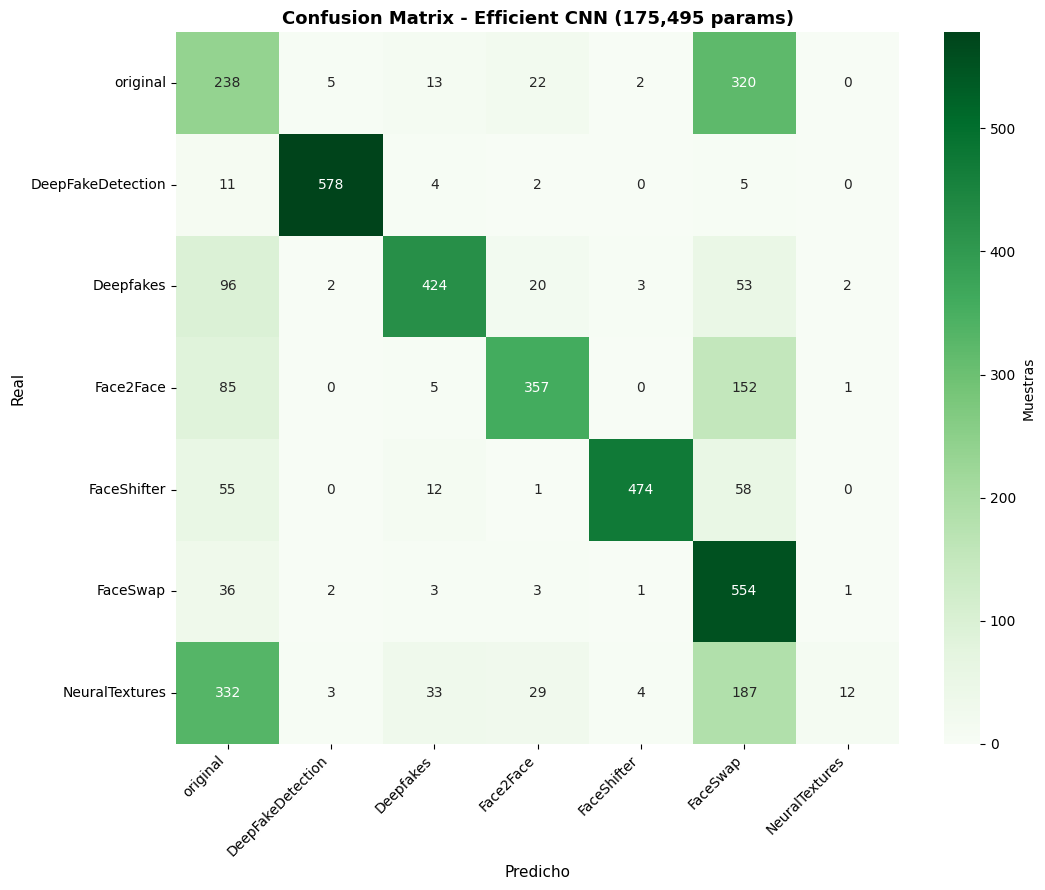

In [ ]:
# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(11, 9))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=METHODS, yticklabels=METHODS,
            cbar_kws={'label': 'Muestras'})
plt.title(f'Confusion Matrix - Efficient CNN ({total_params:,} params)',
          fontsize=13, fontweight='bold')
plt.ylabel('Real', fontsize=11)
plt.xlabel('Predicho', fontsize=11)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(str(CKPT_DIR / 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
print(f"\n✅ Matriz: {CKPT_DIR / 'confusion_matrix.png'}")

✅ Métricas: /content/ffpp_checkpoints_efficient/training_metrics.png


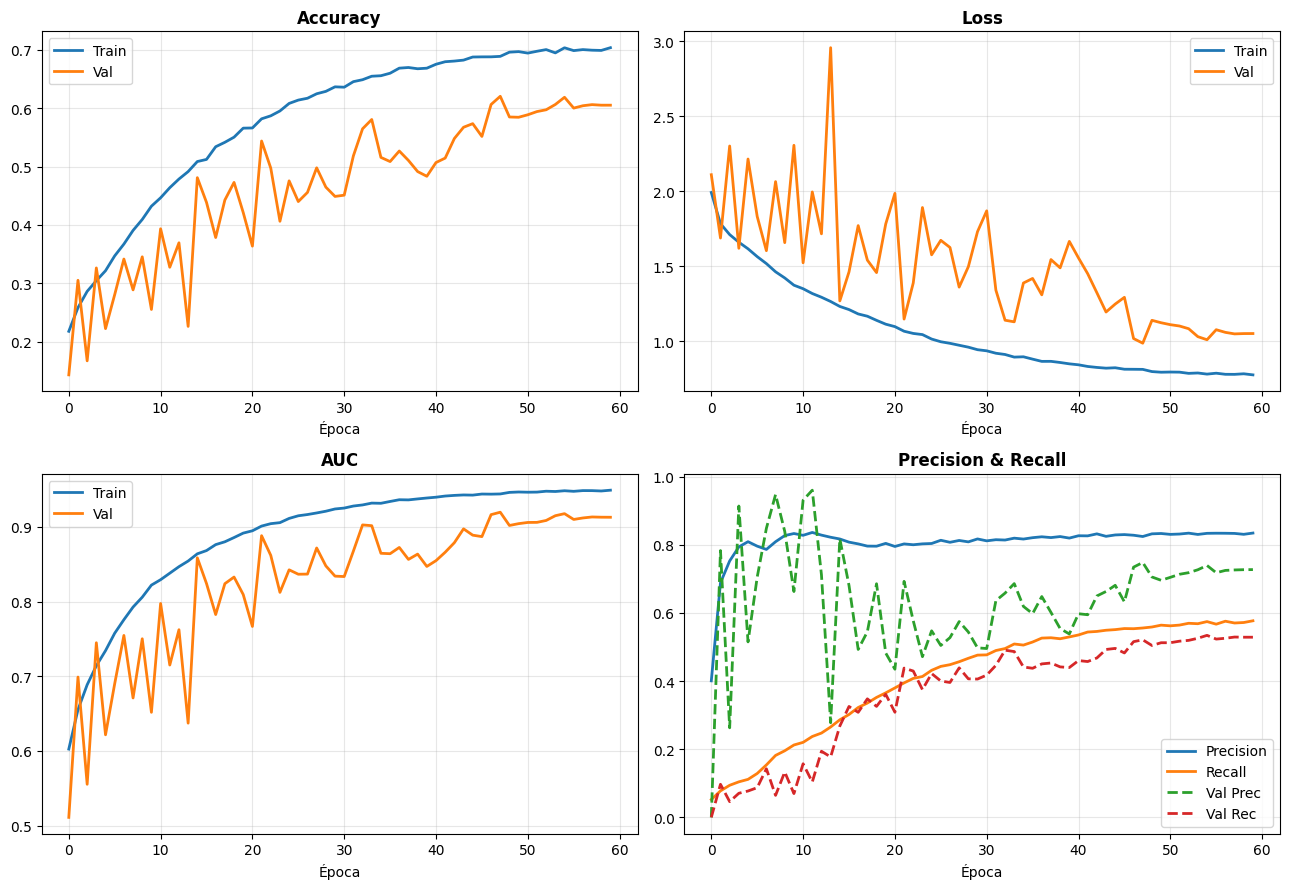

In [ ]:
# Gráficas
fig, axes = plt.subplots(2, 2, figsize=(13, 9))

axes[0, 0].plot(history.history['accuracy'], label='Train', linewidth=2)
axes[0, 0].plot(history.history['val_accuracy'], label='Val', linewidth=2)
axes[0, 0].set_title('Accuracy', fontweight='bold')
axes[0, 0].set_xlabel('Época')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

axes[0, 1].plot(history.history['loss'], label='Train', linewidth=2)
axes[0, 1].plot(history.history['val_loss'], label='Val', linewidth=2)
axes[0, 1].set_title('Loss', fontweight='bold')
axes[0, 1].set_xlabel('Época')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

axes[1, 0].plot(history.history['auc'], label='Train', linewidth=2)
axes[1, 0].plot(history.history['val_auc'], label='Val', linewidth=2)
axes[1, 0].set_title('AUC', fontweight='bold')
axes[1, 0].set_xlabel('Época')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

axes[1, 1].plot(history.history['precision'], label='Precision', linewidth=2)
axes[1, 1].plot(history.history['recall'], label='Recall', linewidth=2)
axes[1, 1].plot(history.history['val_precision'], label='Val Prec', linewidth=2, linestyle='--')
axes[1, 1].plot(history.history['val_recall'], label='Val Rec', linewidth=2, linestyle='--')
axes[1, 1].set_title('Precision & Recall', fontweight='bold')
axes[1, 1].set_xlabel('Época')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(str(CKPT_DIR / 'training_metrics.png'), dpi=300, bbox_inches='tight')
print(f"✅ Métricas: {CKPT_DIR / 'training_metrics.png'}")


## Creación de modelo Deepfake 7-clases
## (Modelo preentrenado)
---
Transfer learning

In [28]:
# ---------- 0) Instalar deps ----------
!pip -q install -U "tensorflow==2.18.0" "mediapipe==0.10.14" "opencv-python-headless==4.10.0.84" \
               "numpy==1.26.4" "pandas==2.2.2" "pyarrow==14.0.2" "tqdm" \
               "scikit-learn==1.5.2" "matplotlib==3.9.2"

# ---------- 1) Imports / Paths / Consts ----------
from pathlib import Path
import os, sys, math, random, json, gc, time
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

print("Python:", sys.version)
print("TF:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))

# ❗️AQUÍ SOLO USAMOS OUT (ya llenado por tu PRIMER script)
OUT  = Path("/content/data_faces_ffpp")        # Caras ya recortadas (JPG/PNG)

from datetime import datetime

EXP_NAME = "efficientnetb0_224"
RUN_ID = datetime.now().strftime("%Y%m%d_%H%M%S")

CKPT_DIR = Path("/content/ffpp_runs") / f"{EXP_NAME}_{RUN_ID}"
CKPT_DIR.mkdir(parents=True, exist_ok=True)
print("Guardando EfficientNetB0 en:", CKPT_DIR)

# Clases (orden fijo, debe coincidir con las carpetas)
METHODS = [
    "original",
    "DeepFakeDetection",
    "Deepfakes",
    "Face2Face",
    "FaceShifter",
    "FaceSwap",
    "NeuralTextures",
]
NUM_CLASSES = len(METHODS)

# Imagen / data
IMG_SIZE = (224, 224)      # mismo tamaño usado al recortar
BATCH = 64
AUTOTUNE = tf.data.AUTOTUNE
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
TF: 2.18.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Guardando EfficientNetB0 en: /content/ffpp_runs/efficientnetb0_224_20251201_181019


In [29]:
# ---------- 2) Utils ----------
def _count_images(p: Path, ext=(".png",".jpg",".jpeg")):
    if not p.exists():
        return 0
    return sum(1 for f in p.rglob("*") if f.suffix.lower() in ext)

In [30]:
# ---------- 3) tf.data (imagen→tensor) ----------
def build_ds(split, batch=BATCH, cache=False):
    ds = tf.keras.utils.image_dataset_from_directory(
        OUT / split,
        labels="inferred",
        label_mode="categorical",  # Cambiar de "int" a "categorical"
        class_names=METHODS,
        image_size=IMG_SIZE,
        batch_size=batch,
        shuffle=True,
        seed=SEED,
        interpolation="bilinear"
    )
    if cache:
        ds = ds.cache()
    return ds.prefetch(AUTOTUNE)

ds_train = build_ds("train", cache=False)   # no cache en train
ds_val   = build_ds("val",   cache=True)    # cache val
ds_test  = build_ds("test",  cache=True)

print("Conteo imágenes por split/clase:")
for sp in ["train", "val", "test"]:
    counts = {m: _count_images(OUT/sp/m) for m in METHODS}
    print(sp, counts)

Found 20975 files belonging to 7 classes.
Found 4200 files belonging to 7 classes.
Found 4200 files belonging to 7 classes.
Conteo imágenes por split/clase:
train {'original': 4196, 'DeepFakeDetection': 2779, 'Deepfakes': 2800, 'Face2Face': 2800, 'FaceShifter': 2800, 'FaceSwap': 2800, 'NeuralTextures': 2800}
val {'original': 600, 'DeepFakeDetection': 600, 'Deepfakes': 600, 'Face2Face': 600, 'FaceShifter': 600, 'FaceSwap': 600, 'NeuralTextures': 600}
test {'original': 600, 'DeepFakeDetection': 600, 'Deepfakes': 600, 'Face2Face': 600, 'FaceShifter': 600, 'FaceSwap': 600, 'NeuralTextures': 600}


In [31]:
# ---------- 4) Cálculo de class_weight (7 clases) ----------
cls_counts = {i: _count_images(OUT/"train"/METHODS[i]) for i in range(NUM_CLASSES)}
tot = sum(cls_counts.values())
class_weight = {i: (tot / (NUM_CLASSES * max(1, cls_counts[i]))) for i in range(NUM_CLASSES)}
print("class_weight:", class_weight)

class_weight: {0: 0.71411548413455, 1: 1.0782398601758083, 2: 1.0701530612244898, 3: 1.0701530612244898, 4: 1.0701530612244898, 5: 1.0701530612244898, 6: 1.0701530612244898}


In [32]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np # Import numpy for .numpy().item() conversion

class RandomJPEG(layers.Layer):
    def __init__(self, qmin=60, qmax=95, **kwargs):
        super().__init__(**kwargs)
        self.qmin = qmin
        self.qmax = qmax

    def _jpeg_compress_decompress_single(self, img_tensor, quality_tensor):
        """Procesa UNA imagen (3D)"""
        # Cast input image tensor to uint8 for JPEG encoding
        img_uint8 = tf.cast(tf.clip_by_value(img_tensor * 255.0, 0.0, 255.0), tf.uint8)

        # Extract the scalar Python integer from the quality tensor
        quality_int = int(quality_tensor.numpy())

        # Perform JPEG compression and decompression
        encoded_img = tf.io.encode_jpeg(img_uint8, quality=quality_int, chroma_downsampling=True)
        decoded_img = tf.io.decode_jpeg(encoded_img, channels=3)

        # Convert back to float32 and normalize to [0, 1]
        return tf.cast(decoded_img, tf.float32) / 255.0

    def call(self, x, training=None):
        if training is False:
            return x

        # Generate a random quality value
        q = tf.random.uniform([], self.qmin, self.qmax + 1, dtype=tf.int32)

        # Process each image in the batch using map_fn
        processed_x = tf.map_fn(
            fn=lambda img: tf.py_function(
                func=self._jpeg_compress_decompress_single,
                inp=[img, q],
                Tout=tf.float32
            ),
            elems=x,
            dtype=tf.float32
        )

        # Restore shape
        processed_x.set_shape(x.shape)
        return processed_x

In [33]:
# ---------- 6) Modelo EfficientNetB0 (warmup + fine-tune) ----------
from tensorflow.keras.applications import EfficientNetB0
# Nota: Ya no importamos 'preprocess_input' porque EfficientNet lo hace interno

def build_model_efficientnetb0():
    inp = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

    # 1. Normalización inicial a [0, 1] para Augmentation
    x = layers.Rescaling(1./255)(inp)

    # 2. Aumentación de datos (Data Augmentation)
    x = layers.RandomFlip("horizontal")(x)
    x = layers.RandomRotation(0.05)(x)
    x = layers.RandomZoom(0.1)(x)
    x = RandomJPEG(60, 95)(x)

    # 3. Adaptación para EfficientNet (Range Scaling)
    # EfficientNet espera valores en rango [0, 255].
    # Como venimos de [0, 1], escalamos x255 usando una capa nativa (no Lambda).
    x = layers.Rescaling(255.0)(x)

    # 4. Base del modelo
    # (EfficientNet tiene su propio 'Rescaling' y 'Normalization' interno)
    base = EfficientNetB0(include_top=False, weights="imagenet")
    base.trainable = False  # Warmup congelado

    y = base(x, training=False)
    y = layers.GlobalAveragePooling2D()(y)
    y = layers.Dropout(0.30)(y)
    out = layers.Dense(NUM_CLASSES, activation="softmax", name="out")(y)

    model = keras.Model(inp, out)
    return model, base

model, base = build_model_efficientnetb0()

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="acc"),
        keras.metrics.TopKCategoricalAccuracy(k=3, name="top3"),
    ]
)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_7 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_2 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_2               │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_2 (RandomZoom)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_jpeg_2 (RandomJPEG)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_8 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out (Dense)                     │ (None, 7)              │         8,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,058,538 (15.48 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [34]:
# ---------- 7) Callbacks ----------
ckpt_every_epoch = str(CKPT_DIR / "weights_epoch_{epoch:03d}.weights.h5")
ckpt_best        = str(CKPT_DIR / "best_by_valACC.keras")
csv_log          = str(CKPT_DIR / "training_log.csv")

cbs = [
    keras.callbacks.ModelCheckpoint(
        filepath=ckpt_every_epoch,
        save_weights_only=True,
        save_freq="epoch",
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=ckpt_best,
        save_weights_only=False,
        monitor="val_acc",
        mode="max",
        save_best_only=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_acc",
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_acc",
        mode="max",
        patience=4,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.CSVLogger(csv_log, append=True),
]

In [35]:
# ---------- 8) Entrenamiento: fase 1 (warmup, base congelada) ----------
WARMUP_EPOCHS = 10
history1 = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=WARMUP_EPOCHS,
    callbacks=cbs,
    class_weight=class_weight,
    verbose=1
)

Epoch 1/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - acc: 0.3002 - loss: 1.7869 - top3: 0.6060
Epoch 1: saving model to /content/ffpp_runs/efficientnetb0_224_20251201_181019/weights_epoch_001.weights.h5

Epoch 1: val_acc improved from -inf to 0.46571, saving model to /content/ffpp_runs/efficientnetb0_224_20251201_181019/best_by_valACC.keras
328/328 ━━━━━━━━━━━━━━━━━━━━ 159s 454ms/step - acc: 0.3005 - loss: 1.7865 - top3: 0.6062 - val_acc: 0.4657 - val_loss: 1.5305 - val_top3: 0.7705 - learning_rate: 0.0010
Epoch 2/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - acc: 0.4677 - loss: 1.4800 - top3: 0.7528
Epoch 2: saving model to /content/ffpp_runs/efficientnetb0_224_20251201_181019/weights_epoch_002.weights.h5

Epoch 2: val_acc improved from 0.46571 to 0.49952, saving model to /content/ffpp_runs/efficientnetb0_224_20251201_181019/best_by_valACC.keras
328/328 ━━━━━━━━━━━━━━━━━━━━ 147s 445ms/step - acc: 0.4677 - loss: 1.4800 - top3: 0.7529 - val_acc: 0.4995 - val_loss: 1.4400 - val_top3

In [36]:
# ---------- 9) Fine-tune: descongela parte final ----------
n_layers = len(base.layers)
for li, lyr in enumerate(base.layers):
    lyr.trainable = (li >= n_layers // 2)

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # LR bajo para fine-tune
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="acc"),
        keras.metrics.TopKCategoricalAccuracy(k=3, name="top3"),
    ]
)

FINE_EPOCHS = 10
history2 = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=FINE_EPOCHS,
    callbacks=cbs,
    class_weight=class_weight,
    verbose=1
)

Epoch 1/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - acc: 0.3359 - loss: 1.8708 - top3: 0.6613
Epoch 1: saving model to /content/ffpp_runs/efficientnetb0_224_20251201_181019/weights_epoch_001.weights.h5

Epoch 1: val_acc did not improve from 0.56738
328/328 ━━━━━━━━━━━━━━━━━━━━ 202s 546ms/step - acc: 0.3360 - loss: 1.8704 - top3: 0.6614 - val_acc: 0.5126 - val_loss: 1.3808 - val_top3: 0.8052 - learning_rate: 1.0000e-05
Epoch 2/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - acc: 0.4879 - loss: 1.4375 - top3: 0.7852
Epoch 2: saving model to /content/ffpp_runs/efficientnetb0_224_20251201_181019/weights_epoch_002.weights.h5

Epoch 2: val_acc improved from 0.56738 to 0.58548, saving model to /content/ffpp_runs/efficientnetb0_224_20251201_181019/best_by_valACC.keras
328/328 ━━━━━━━━━━━━━━━━━━━━ 188s 574ms/step - acc: 0.4879 - loss: 1.4374 - top3: 0.7853 - val_acc: 0.5855 - val_loss: 1.2171 - val_top3: 0.8574 - learning_rate: 1.0000e-05
Epoch 3/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/ste

In [37]:
# Habilitar deserialización unsafe temporalmente
keras.config.enable_unsafe_deserialization()

best_model = keras.models.load_model(
    ckpt_best,
    custom_objects={"RandomJPEG": RandomJPEG}
)
print("Cargado mejor modelo:", ckpt_best)

Cargado mejor modelo: /content/ffpp_runs/efficientnetb0_224_20251201_181019/best_by_valACC.keras


In [43]:
# ==============================================================================
# 11) FUSIÓN DE HISTORIALES (Warmup + Fine-tuning)
# ==============================================================================
full_history = {}
# Unimos los historiales si existen ambos, sino usa solo el que tengas
if 'history1' in locals() and 'history2' in locals():
    for key in history1.history.keys():
        full_history[key] = history1.history[key] + history2.history[key]
else:
    # Fallback por si acaso solo corriste una parte
    full_history = history2.history if 'history2' in locals() else history1.history

In [44]:

# ==============================================================================
# 12) EVALUACIÓN DETALLADA (CORREGIDO)
# ==============================================================================
print("\n" + "="*70)
print("📊 EVALUACIÓN EN TEST SET (EfficientNetB0)")
print("="*70)

# --- CORRECCIÓN AQUÍ: Forzamos la regeneración de y_true/y_pred ---
print("Generando predicciones y convirtiendo a índices...")
y_true, y_pred, y_prob = [], [], []

for bx, by in ds_test:
    p = best_model.predict(bx, verbose=0)
    y_prob.append(p)

    y_true.append(np.argmax(by.numpy(), axis=1))

    y_pred.append(np.argmax(p, axis=1))

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)D
y_prob = np.concatenate(y_prob)

# ------------------------------------------------------------------

# Calcular métricas globales con sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix

acc_score = accuracy_score(y_true, y_pred)
prec_score = precision_score(y_true, y_pred, average='macro', zero_division=0)
rec_score = recall_score(y_true, y_pred, average='macro', zero_division=0)

print("\n🎯 RESULTADOS FINALES:")
print(f"  {'accuracy':15s}: {acc_score:.4f}")
print(f"  {'precision':15s}: {prec_score:.4f}")
print(f"  {'recall':15s}: {rec_score:.4f}")


📊 EVALUACIÓN EN TEST SET (EfficientNetB0)
Generando predicciones y convirtiendo a índices...

🎯 RESULTADOS FINALES:
  accuracy       : 0.8138
  precision      : 0.8120
  recall         : 0.8138


In [45]:
# === ANÁLISIS DETALLADO ===
import seaborn as sns
import matplotlib.pyplot as plt

print("\n📋 CLASSIFICATION REPORT:")
print("="*70)
print(classification_report(y_true, y_pred, target_names=METHODS, digits=4))

print("\n🎯 ACCURACY POR CLASE:")
print("="*70)
for i, method in enumerate(METHODS):
    mask = np.array(y_true) == i
    if mask.sum() > 0:
        correct = (np.array(y_pred)[mask] == i).sum()
        total = mask.sum()
        acc = correct / total
        print(f"{method:20s}: {acc*100:6.2f}% ({correct:4d}/{total:4d})")


📋 CLASSIFICATION REPORT:
                   precision    recall  f1-score   support

         original     0.6868    0.4350    0.5327       600
DeepFakeDetection     0.9597    0.9933    0.9762       600
        Deepfakes     0.9043    0.9133    0.9088       600
        Face2Face     0.7523    0.9417    0.8364       600
      FaceShifter     0.8978    0.8050    0.8489       600
         FaceSwap     0.7332    0.9483    0.8270       600
   NeuralTextures     0.7500    0.6600    0.7021       600

         accuracy                         0.8138      4200
        macro avg     0.8120    0.8138    0.8046      4200
     weighted avg     0.8120    0.8138    0.8046      4200


🎯 ACCURACY POR CLASE:
original            :  43.50% ( 261/ 600)
DeepFakeDetection   :  99.33% ( 596/ 600)
Deepfakes           :  91.33% ( 548/ 600)
Face2Face           :  94.17% ( 565/ 600)
FaceShifter         :  80.50% ( 483/ 600)
FaceSwap            :  94.83% ( 569/ 600)
NeuralTextures      :  66.00% ( 396/ 600)



✅ Matriz guardada: /content/ffpp_runs/efficientnetb0_224_20251201_181019/confusion_matrix_seaborn.png


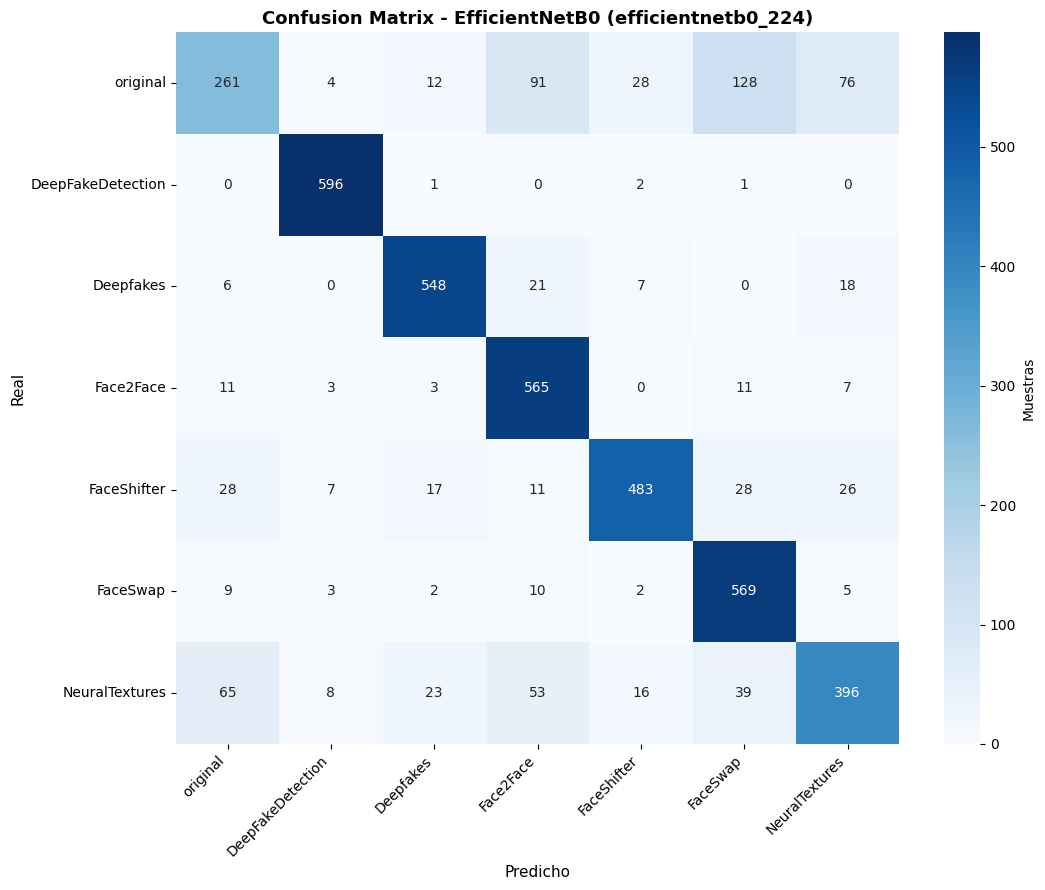

In [47]:
# === MATRIZ DE CONFUSIÓN (Seaborn Style) ===
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(11, 9))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=METHODS, yticklabels=METHODS,
            cbar_kws={'label': 'Muestras'})
plt.title(f'Confusion Matrix - EfficientNetB0 ({EXP_NAME})',
          fontsize=13, fontweight='bold')
plt.ylabel('Real', fontsize=11)
plt.xlabel('Predicho', fontsize=11)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(str(CKPT_DIR / 'confusion_matrix_seaborn.png'), dpi=300, bbox_inches='tight')
print(f"\n✅ Matriz guardada: {CKPT_DIR / 'confusion_matrix_seaborn.png'}")

💾 Modelo guardado: /content/ffpp_runs/efficientnetb0_224_20251201_181019/best_final_efficientnet.keras


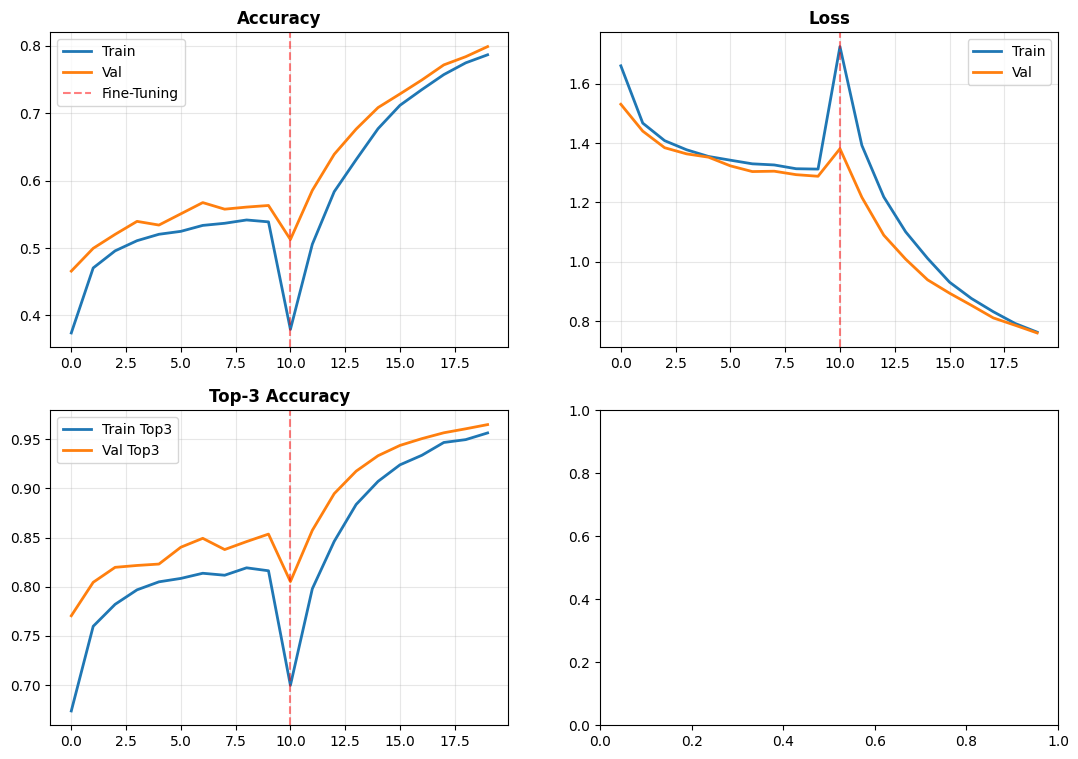

In [49]:
# === GRÁFICAS DE ENTRENAMIENTO ===
fig, axes = plt.subplots(2, 2, figsize=(13, 9))

# 1. Accuracy
acc_key = 'acc' if 'acc' in full_history else 'accuracy'
val_acc_key = 'val_' + acc_key

if acc_key in full_history:
    axes[0, 0].plot(full_history[acc_key], label='Train', linewidth=2)
    axes[0, 0].plot(full_history[val_acc_key], label='Val', linewidth=2)
    axes[0, 0].axvline(x=WARMUP_EPOCHS, color='r', linestyle='--', alpha=0.5, label='Fine-Tuning')
    axes[0, 0].set_title('Accuracy', fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)

# 2. Loss
if 'loss' in full_history:
    axes[0, 1].plot(full_history['loss'], label='Train', linewidth=2)
    axes[0, 1].plot(full_history['val_loss'], label='Val', linewidth=2)
    axes[0, 1].axvline(x=WARMUP_EPOCHS, color='r', linestyle='--', alpha=0.5)
    axes[0, 1].set_title('Loss', fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)

# 3. Top-3
if 'top3' in full_history:
    axes[1, 0].plot(full_history['top3'], label='Train Top3', linewidth=2)
    axes[1, 0].plot(full_history['val_top3'], label='Val Top3', linewidth=2)
    axes[1, 0].axvline(x=WARMUP_EPOCHS, color='r', linestyle='--', alpha=0.5)
    axes[1, 0].set_title('Top-3 Accuracy', fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)

# Guardar modelo final
best_path = str(CKPT_DIR / "best_final_efficientnet.keras")
best_model.save(best_path)
print(f"💾 Modelo guardado: {best_path}")